This file tries to apply the methods in "Hands-on Machine Learning with Scikit-Learn and TensorFlow" to solve the invasive competition in Kaggle.

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
FOLDER_NAME = "invasive"
image_path = "./images/"+ CHAPTER_ID
if not os.path.isdir(image_path):
        os.makedirs(image_path)

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", FOLDER_NAME, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Import the pictures and the tensorflow model

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

In [3]:
import tensorflow as tf

In [4]:
import sys
import tarfile
from six.moves import urllib

TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_PATH = os.path.join("datasets", "inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH):
    if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
        return
    tgz_path = os.path.join(path, "inception_v3.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    inception_tgz = tarfile.open(tgz_path)
    inception_tgz.extractall(path=path)
    inception_tgz.close()
    os.remove(tgz_path)

In [5]:
fetch_pretrained_inception_v3()

In [6]:
import re

CLASS_NAME_REGEX = re.compile(r"^n\d+\s+(.*)\s*$", re.M | re.U)

def load_class_names():
    with open(os.path.join("datasets", "inception", "imagenet_class_names.txt"), "rb") as f:
        content = f.read().decode("utf-8")
        return CLASS_NAME_REGEX.findall(content)

In [7]:
class_names = load_class_names()

In [8]:
class_names[:5]

['tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri',
 'hammerhead, hammerhead shark']

In [9]:
import pandas as pd
labels_df = pd.read_csv("train_labels.csv")
labels_df.head()

,name,invasive
0,1,0
1,2,0
2,3,1
3,4,0
4,5,1


In [10]:
from skimage import data, io, filters
index = 2
filename = str(index) + ".jpg"
dirname = "train"
path = os.path.abspath(os.path.join(dirname, filename))
image = io.imread(path)

In [11]:
np.shape(image)

(866, 1154, 3)

# Load image data

In [12]:
width = 299
height = 299
channels = 3

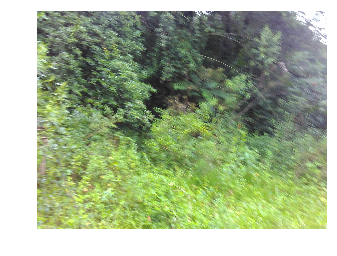

In [13]:
import matplotlib.image as mpimg
test_image = mpimg.imread(path)[:, :, :channels]
plt.imshow(test_image)
plt.axis("off")
plt.show()

In [14]:
np.shape(test_image)

(866, 1154, 3)

## Distort the pictures to increase randomness

In [15]:
from scipy.misc import imresize

def prepare_image(image, target_width = 299, target_height = 299, max_zoom = 0.2):
    """Zooms and crops the image randomly for data augmentation."""

    # First, let's find the largest bounding box with the target size ratio that fits within the image
    height = image.shape[0]
    width = image.shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    crop_width = width if crop_vertically else int(height * target_image_ratio)
    crop_height = int(width / target_image_ratio) if crop_vertically else height
        
    # Now let's shrink this bounding box by a random factor (dividing the dimensions by a random number
    # between 1.0 and 1.0 + `max_zoom`.
    resize_factor = np.random.rand() * max_zoom + 1.0
    crop_width = int(crop_width / resize_factor)
    crop_height = int(crop_height / resize_factor)
    
    # Next, we can select a random location on the image for this bounding box.
    x0 = np.random.randint(0, width - crop_width)
    y0 = np.random.randint(0, height - crop_height)
    x1 = x0 + crop_width
    y1 = y0 + crop_height
    
    # Let's crop the image using the random bounding box we built.
    image = image[y0:y1, x0:x1]

    # Let's also flip the image horizontally with 50% probability:
    if np.random.rand() < 0.5:
        image = np.fliplr(image)

    # Now, let's resize the image to the target dimensions.
    image = imresize(image, (target_width, target_height))
    
    # Finally, the Convolution Neural Network expects colors represented as
    # 32-bit floats ranging from 0.0 to 1.0:
    return image.astype(np.float32) / 255

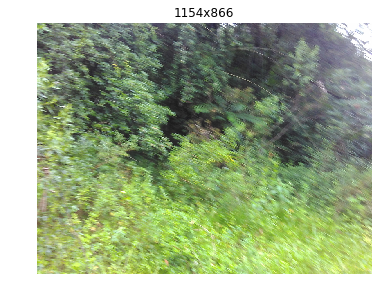

In [16]:
plt.figure(figsize=(6, 8))
plt.imshow(test_image)
plt.title("{}x{}".format(test_image.shape[1], test_image.shape[0]))
plt.axis("off")
plt.show()

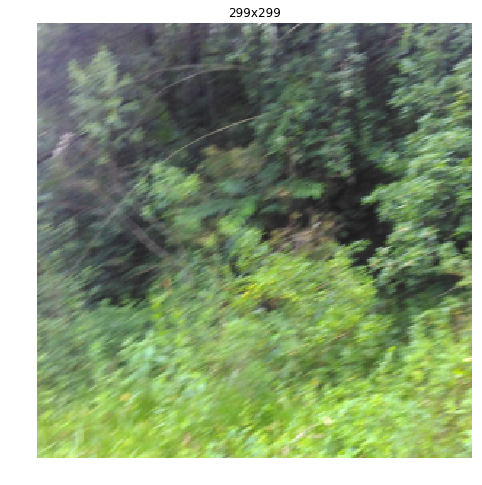

In [17]:
prepared_image = prepare_image(test_image)

plt.figure(figsize=(8, 8))
plt.imshow(prepared_image)
plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
plt.axis("off")
plt.show()

In [18]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

reset_graph()

X = tf.placeholder(tf.float32, shape=[None, 299, 299, 3], name="X")
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(
        X, num_classes=1001, is_training=False)
predictions = end_points["Predictions"]
saver = tf.train.Saver()

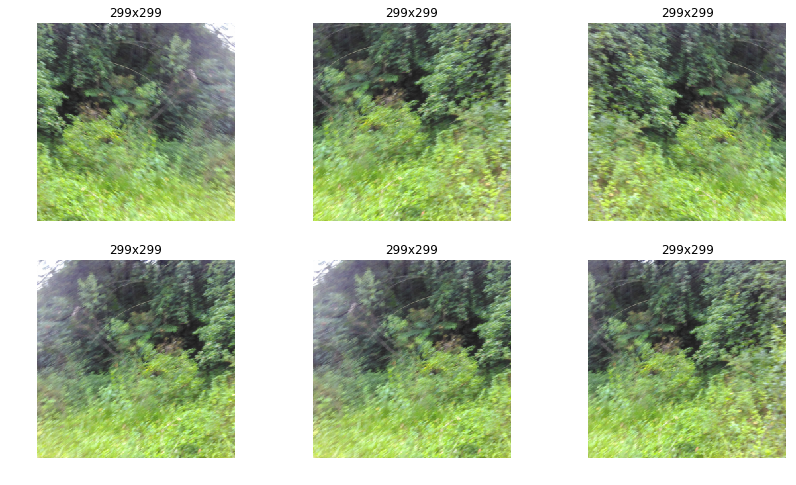

In [19]:
rows, cols = 2, 3

plt.figure(figsize=(14, 8))
for row in range(rows):
    for col in range(cols):
        prepared_image = prepare_image(test_image)
        plt.subplot(rows, cols, row * cols + col + 1)
        plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
        plt.imshow(prepared_image)
        plt.axis("off")
plt.show()

In [20]:
with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    # ...

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt


In [21]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

reset_graph()

X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="X")
training = tf.placeholder_with_default(False, shape=[])
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=training)

inception_saver = tf.train.Saver()

In [22]:
logits.op.inputs[0]

<tf.Tensor 'InceptionV3/Logits/Conv2d_1c_1x1/BiasAdd:0' shape=(?, 1, 1, 1001) dtype=float32>

In [23]:
logits.op.inputs[0].op.inputs[0]

<tf.Tensor 'InceptionV3/Logits/Conv2d_1c_1x1/convolution:0' shape=(?, 1, 1, 1001) dtype=float32>

In [24]:
logits.op.inputs[0].op.inputs[0].op.inputs[0]

<tf.Tensor 'InceptionV3/Logits/Dropout_1b/cond/Merge:0' shape=(?, 1, 1, 2048) dtype=float32>

In [25]:
end_points

{'AuxLogits': <tf.Tensor 'InceptionV3/AuxLogits/SpatialSqueeze:0' shape=(?, 1001) dtype=float32>,
 'Conv2d_1a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_1a_3x3/Relu:0' shape=(?, 149, 149, 32) dtype=float32>,
 'Conv2d_2a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2a_3x3/Relu:0' shape=(?, 147, 147, 32) dtype=float32>,
 'Conv2d_2b_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2b_3x3/Relu:0' shape=(?, 147, 147, 64) dtype=float32>,
 'Conv2d_3b_1x1': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_3b_1x1/Relu:0' shape=(?, 73, 73, 80) dtype=float32>,
 'Conv2d_4a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_4a_3x3/Relu:0' shape=(?, 71, 71, 192) dtype=float32>,
 'Logits': <tf.Tensor 'InceptionV3/Logits/SpatialSqueeze:0' shape=(?, 1001) dtype=float32>,
 'MaxPool_3a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_3a_3x3/MaxPool:0' shape=(?, 73, 73, 64) dtype=float32>,
 'MaxPool_5a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_5a_3x3/MaxPool:0' shape=(?, 35, 35, 192) dtype=floa

In [26]:
end_points["PreLogits"]

<tf.Tensor 'InceptionV3/Logits/Dropout_1b/cond/Merge:0' shape=(?, 1, 1, 2048) dtype=float32>

In [27]:
prelogits = tf.squeeze(end_points["PreLogits"], axis=[1, 2])

In [28]:
n_outputs = 2

with tf.name_scope("new_output_layer"):
    invasive_logits = tf.layers.dense(prelogits, n_outputs, name="invasive_logits")
    Y_proba = tf.nn.softmax(invasive_logits, name="Y_proba")

In [29]:
y = tf.placeholder(tf.int32, shape=[None])

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=invasive_logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    invasive_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="invasive_logits")
    training_op = optimizer.minimize(loss, var_list=invasive_vars)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(invasive_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [30]:
[v.name for v in invasive_vars]

['invasive_logits/kernel:0', 'invasive_logits/bias:0']

In [31]:

invasive_path_and_label = []
for i in range(len(labels_df)):
    invasive_path_and_label.append((os.path.abspath(os.path.join("train", str(labels_df['name'][i]) + ".jpg")), labels_df['invasive'][i]))

In [32]:
invasive_path_and_label[:3]

[('/Users/yuanxue/Desktop/Kaggle/Invasive/train/1.jpg', 0),
 ('/Users/yuanxue/Desktop/Kaggle/Invasive/train/2.jpg', 0),
 ('/Users/yuanxue/Desktop/Kaggle/Invasive/train/3.jpg', 1)]

In [33]:
test_ratio = 0.2
train_size = int(len(invasive_path_and_label) * (1 - test_ratio))

np.random.shuffle(invasive_path_and_label)

invasive_train = invasive_path_and_label[:train_size]
invasive_test = invasive_path_and_label[train_size:]

In [34]:
invasive_train[:4]

[('/Users/yuanxue/Desktop/Kaggle/Invasive/train/423.jpg', 1),
 ('/Users/yuanxue/Desktop/Kaggle/Invasive/train/1290.jpg', 1),
 ('/Users/yuanxue/Desktop/Kaggle/Invasive/train/209.jpg', 0),
 ('/Users/yuanxue/Desktop/Kaggle/Invasive/train/1634.jpg', 1)]

In [35]:
from random import sample

def prepare_batch(invasive_index_and_label, batch_size):
    batch_invasive = sample(invasive_index_and_label, batch_size)
    images = [mpimg.imread(path)[:, :, :channels] for path, labels in batch_invasive]
    prepared_images = [prepare_image(image) for image in images]
    X_batch = np.stack(prepared_images)
    y_batch = np.array([labels for path, labels in batch_invasive], dtype=np.int32)
    return X_batch, y_batch

In [36]:
X_batch, y_batch = prepare_batch(invasive_train, batch_size=4)

In [37]:
y_batch

array([1, 1, 0, 1], dtype=int32)

In [38]:
X_batch.shape

(4, 299, 299, 3)

In [39]:
X_batch.dtype

dtype('float32')

In [40]:
y_batch.shape

(4,)

In [41]:
y_batch.dtype

dtype('int32')

In [42]:
X_test, y_test = prepare_batch(invasive_test, batch_size=len(invasive_test))

In [43]:
X_test.shape

(459, 299, 299, 3)

# Train the model

In [86]:
n_epochs = 10
batch_size = 50
n_iterations_per_epoch = len(invasive_train) // batch_size

with tf.Session() as sess:
    init.run()
    inception_saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)

    for epoch in range(n_epochs):
        print("Epoch", epoch, end="")
        for iteration in range(n_iterations_per_epoch):
            print(".", end="")
            X_batch, y_batch = prepare_batch(invasive_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})

        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("  Train accuracy:", acc_train)

        save_path = saver.save(sess, "./my_invasive_model")

    print("Computing final accuracy on the test set (this will take a while)...")
    acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
    print("Test accuracy:", acc_test)

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt
Epoch 0....................................  Train accuracy: 0.68
Epoch 1....................................  Train accuracy: 0.9
Epoch 2....................................  Train accuracy: 0.9
Epoch 3....................................  Train accuracy: 0.68
Epoch 4....................................  Train accuracy: 0.68
Epoch 5....................................  Train accuracy: 0.74
Epoch 6....................................  Train accuracy: 0.76
Epoch 7....................................  Train accuracy: 0.82
Epoch 8....................................  Train accuracy: 0.68
Epoch 9....................................  Train accuracy: 0.54
Computing final accuracy on the test set (this will take a while)...
Test accuracy: 0.662309


In [44]:
with tf.Session() as sess:
    saver.restore(sess, "./my_invasive_model")
    acc_test = accuracy.eval(feed_dict={X: X_test[:5], y: y_test[:5]})
    print("Test accuracy:", acc_test)

INFO:tensorflow:Restoring parameters from ./my_flowers_model
Test accuracy: 0.6


# Predict

In [43]:
with tf.Session() as sess:
    saver.restore(sess, "./my_flowers_model")

INFO:tensorflow:Restoring parameters from ./my_flowers_model


In [44]:
predictions

<tf.Tensor 'InceptionV3/Predictions/Reshape_1:0' shape=(?, 1001) dtype=float32>

In [45]:
accuracy

<tf.Tensor 'eval/Mean:0' shape=() dtype=float32>

In [64]:
a = np.zeros(shape=(len(X_test),2))
import math
n_cate = math.floor(len(X_test)/5)
with tf.Session() as sess:
    saver.restore(sess, "./my_invasive_model")
    for i in range(0, n_cate+1):
        p = Y_proba.eval(feed_dict={X: X_test[i*5:min(len(X_test),i*5+5)]})
        a[i*5:min(len(X_test),i*5+5)] = p
        if i % 10 == 0:
            print("Processing the %d'th loop.\n" % i)
    


INFO:tensorflow:Restoring parameters from ./my_flowers_model
Processing the 0'th loop.

Processing the 10'th loop.

Processing the 20'th loop.

Processing the 30'th loop.

Processing the 40'th loop.

Processing the 50'th loop.

Processing the 60'th loop.

Processing the 70'th loop.

Processing the 80'th loop.

Processing the 90'th loop.



In [34]:
import glob
path = os.path.join("test",'*.jpg')
files = glob.glob(path)
files[:5]

['test/1.jpg', 'test/10.jpg', 'test/100.jpg', 'test/1000.jpg', 'test/1001.jpg']

In [35]:
text_index = []
home_dir = os.getcwd()
file_path_list = []
import re
for i in range(1,len(files)):
    text_index.append(int(''.join(re.findall(r'\d+', files[i]))))
    file_path_list.append(os.path.join(home_dir,files[i]))
file_path_list[:5]


['/Users/yuanxue/Desktop/Kaggle/Invasive/test/10.jpg',
 '/Users/yuanxue/Desktop/Kaggle/Invasive/test/100.jpg',
 '/Users/yuanxue/Desktop/Kaggle/Invasive/test/1000.jpg',
 '/Users/yuanxue/Desktop/Kaggle/Invasive/test/1001.jpg',
 '/Users/yuanxue/Desktop/Kaggle/Invasive/test/1002.jpg']

In [70]:
len(files)

1531

In [54]:
import math
math.floor(len(X_test)/5)

91

In [46]:
def prepare_test(file_path_list):
    prepared_images = []
    for i in range(0,len(file_path_list)):
        image = mpimg.imread(file_path_list[i])[:, :, :channels]
        prepared_images.append(prepare_image(image))
        if i % 50 ==0:
            print("Processing %d'th image in %d.\n" % (i,len(file_path_list)))
    X_batch = np.stack(prepared_images)
    return X_batch

In [47]:
test_final = prepare_test(file_path_list)

Processing 0'th image in 1530.

Processing 50'th image in 1530.

Processing 100'th image in 1530.

Processing 150'th image in 1530.

Processing 200'th image in 1530.

Processing 250'th image in 1530.

Processing 300'th image in 1530.

Processing 350'th image in 1530.

Processing 400'th image in 1530.

Processing 450'th image in 1530.

Processing 500'th image in 1530.

Processing 550'th image in 1530.

Processing 600'th image in 1530.

Processing 650'th image in 1530.

Processing 700'th image in 1530.

Processing 750'th image in 1530.

Processing 800'th image in 1530.

Processing 850'th image in 1530.

Processing 900'th image in 1530.

Processing 950'th image in 1530.

Processing 1000'th image in 1530.

Processing 1050'th image in 1530.

Processing 1100'th image in 1530.

Processing 1150'th image in 1530.

Processing 1200'th image in 1530.

Processing 1250'th image in 1530.

Processing 1300'th image in 1530.

Processing 1350'th image in 1530.

Processing 1400'th image in 1530.

Processi

In [49]:
a = np.zeros(shape=(len(test_final),2))
import math
n_cate = math.floor(len(test_final)/5)
with tf.Session() as sess:
    saver.restore(sess, "./my_invasive_model")
    for i in range(0, n_cate+1):
        p = Y_proba.eval(feed_dict={X: test_final[i*5:min(len(test_final),i*5+5)]})
        a[i*5:min(len(test_final),i*5+5)] = p
        if i % 10 == 0:
            print("Processing the %d'th loop.\n" % i)
    

INFO:tensorflow:Restoring parameters from ./my_flowers_model
Processing the 0'th loop.

Processing the 10'th loop.

Processing the 20'th loop.

Processing the 30'th loop.

Processing the 40'th loop.

Processing the 50'th loop.

Processing the 60'th loop.

Processing the 70'th loop.

Processing the 80'th loop.

Processing the 90'th loop.

Processing the 100'th loop.

Processing the 110'th loop.

Processing the 120'th loop.

Processing the 130'th loop.

Processing the 140'th loop.

Processing the 150'th loop.

Processing the 160'th loop.

Processing the 170'th loop.

Processing the 180'th loop.

Processing the 190'th loop.

Processing the 200'th loop.

Processing the 210'th loop.

Processing the 220'th loop.

Processing the 230'th loop.

Processing the 240'th loop.

Processing the 250'th loop.

Processing the 260'th loop.

Processing the 270'th loop.

Processing the 280'th loop.

Processing the 290'th loop.

Processing the 300'th loop.



In [69]:
df = pd.DataFrame({'name': text_index, 'invasive': a[:,0]})

In [64]:
df.sort_values(['name'], ascending=[1])
df = df[['name','invasive']]

In [65]:
df.to_csv('invasive_prediction.csv',index = False)

In [68]:
type(text_index[0])

int